In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
# !pip install deepforest


Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml
Reading config file: /usr/local/lib/python3.11/dist-packages/deepforest/data/deepforest_config.yml


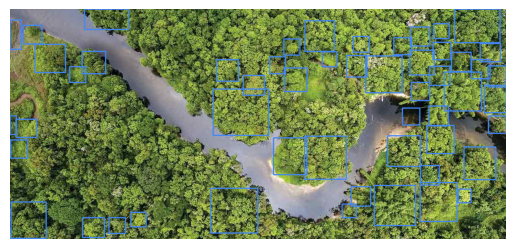

In [22]:
from deepforest import main
from deepforest import get_data
from deepforest.visualize import plot_results
model = main.deepforest()

# Load a pretrained tree detection model from Hugging Face 
model.load_model(model_name="weecology/deepforest-tree", revision="main")
sample_image_path = get_data("/kaggle/working/amazon_forest.jpg")
img = model.predict_image(path=sample_image_path)
plot_results(img)

In [29]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, SamModel, SamProcessor

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"


In [52]:

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "https://imgs.mongabay.com/wp-content/uploads/sites/30/2020/02/27132645/Banner-5.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# Check for cats and remote controls
# VERY important: text queries need to be lowercased + end with a dot
text = "a forest."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]]
)


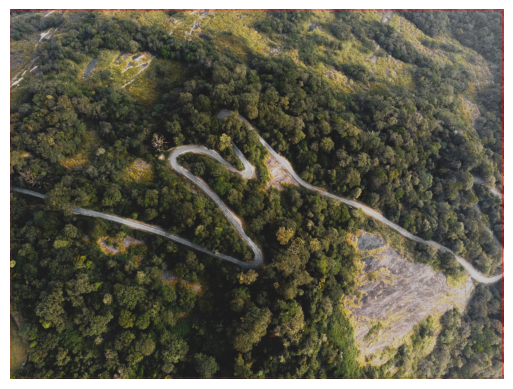

In [53]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# Load the first (and only) result
boxes = results[0]["boxes"]
scores = results[0]["scores"]
labels = results[0]["labels"]

# Convert image to editable format
draw = ImageDraw.Draw(image)

# Optional: define a font
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = ImageFont.load_default()

# Draw boxes
for box, score, label in zip(boxes, scores, labels):
    box = box.tolist()
    draw.rectangle(box, outline="red", width=3)
    draw.text((box[0], box[1] - 10), f"{label}: {score:.2f}", fill="red", font=font)

# Show image
plt.imshow(image)
plt.axis("off")
plt.show()


[[[tensor([[   8.3738,    7.4895, 4036.3918, 3022.4558]])]]]


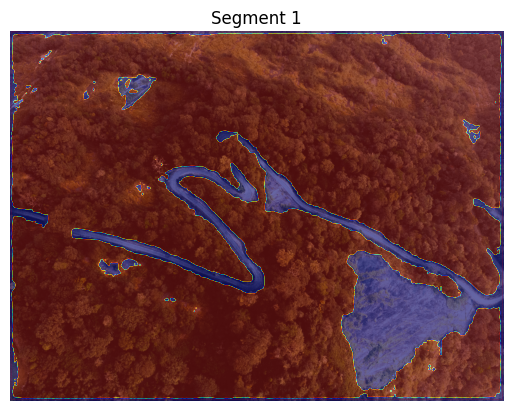

In [54]:
sam_model_id = "facebook/sam-vit-huge"
sam_processor = SamProcessor.from_pretrained(sam_model_id)
sam_model = SamModel.from_pretrained(sam_model_id).to(device)

# Step 5: Segment each Grounding DINO box using SAM
boxes = results[0]["boxes"]
for i, box in enumerate(boxes):
    # Convert box to format [x0, y0, x1, y1] (already is)
    box = box.unsqueeze(0).to('cpu')
    box = [[[box]]]
    print(box)
    sam_inputs = sam_processor(image, input_boxes=box, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = sam_model(**sam_inputs)

    mask = sam_processor.post_process_masks(outputs.pred_masks.cpu(), sam_inputs["original_sizes"].cpu(), sam_inputs["reshaped_input_sizes"].cpu())[0][0]

    # Show segmented mask
    plt.figure()
    plt.imshow(np.array(image))
    plt.imshow(mask[0], alpha=0.5, cmap="jet")
    plt.title(f"Segment {i+1}")
    plt.axis("off")
    plt.show()